# Quantum Algorithms

In [1]:
from openql import openql as ql
import numpy as np
from utils import simulate, plot_histogram, random_state


In [89]:
ql.initialize()
compiler = ql.Compiler("compiler", "./config/compiler-config.json")

platform = ql.Platform("platform", "none")
platform.set_compiler(compiler=compiler)


## Bernstein-Vazirani Algorithm

In [3]:
N = 5  # length of the secret message
secret = random_state(N)  # generate secret message

secret


'11000'

In [4]:
bv_program = ql.Program("bernstein-vazirani", platform=platform, qubit_count=N + 1)
bv_kernel = ql.Kernel("bv-kernel", platform=platform, qubit_count=N + 1)

# apply Hadamard gate to first N qubits
for qubit in range(N):
    bv_kernel.hadamard(qubit)

# apply X gate and Hadamard gate to the last qubit
bv_kernel.x(N)
bv_kernel.hadamard(N)

# oracle
for i, qubit in enumerate(secret):
    if qubit == "1":
        bv_kernel.cnot(i, N)

# reverse Hadamards and measure
for qubit in range(N):
    bv_kernel.hadamard(qubit)
    bv_kernel.measure(qubit)

bv_program.add_kernel(bv_kernel)
bv_program.compile()


In [5]:
counts = simulate(program=bv_program, measured=range(N), shots=1)


In [6]:
print(f"{counts=}")
print(f"{secret=}")


counts={'11000': 1}
secret='11000'


## Teleportation Algorithm

In [7]:
tp_program = ql.Program("teleportation", platform=platform, qubit_count=3)
tp_kernel = ql.Kernel("tp-kernel", platform=platform, qubit_count=3)

# prepare state that will be sent, ie |+>
tp_kernel.hadamard(0)

# create bell state for Alice and Bob
tp_kernel.hadamard(1)
tp_kernel.cnot(1, 2)

# expansion in Bell's basis by Alice
tp_kernel.cnot(0, 1)
tp_kernel.hadamard(0)

# Bob's state translation
tp_kernel.cnot(1, 2)
tp_kernel.cz(0, 2)

# make measurements
tp_kernel.measure(0)
tp_kernel.measure(1)
tp_kernel.measure(2)

tp_program.add_kernel(tp_kernel)
tp_program.compile()


In [8]:
counts = simulate(program=tp_program, measured=[2], shots=1024)


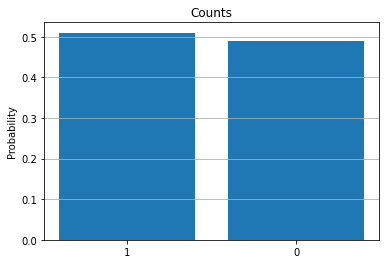

In [9]:
plot_histogram(counts)


## Grover's Algorithm

### Single-solution oracle

In [10]:
# choose random state as a winner
winner = random_state(2)
winner

'11'

In [11]:
# initialize program and kernel
grs_program = ql.Program("grovers-single", platform=platform, qubit_count=2)
grs_kernel = ql.Kernel("grs-kernel", platform=platform, qubit_count=2)

# apply Hadamard to all qubits
# start with equally distributed probabilities
grs_kernel.hadamard(0)
grs_kernel.hadamard(1)

# oracle based on random winner
grs_kernel.cz(0, 1)
for i, qubit in enumerate(winner):
    if qubit == "0":
        grs_kernel.x(i)
        
# amplification
grs_kernel.hadamard(0)
grs_kernel.hadamard(1)
grs_kernel.z(0)
grs_kernel.z(1)
grs_kernel.cz(0, 1)
grs_kernel.hadamard(0)
grs_kernel.hadamard(1)

# measurements
grs_kernel.measure(0)
grs_kernel.measure(1)

grs_program.add_kernel(grs_kernel)
grs_program.compile()

In [12]:
counts = simulate(program=grs_program, shots=1)

In [13]:
counts


{'11': 1}

### Double-solution oracle

In [14]:
# choose two random winners
winner1 = "100"
winner2 = "111"

In [15]:
grd_program = ql.Program("grovers-double", platform=platform, qubit_count=3)
grd_kernel = ql.Kernel("grd-kernel", platform=platform, qubit_count=3)

for qubit in range(3):
    grd_kernel.hadamard(qubit)

# oracle for winners: 100 and 111
grd_kernel.z(0)
grd_kernel.cz(0, 1)
grd_kernel.cz(0, 2)

# amplification
for qubit in range(3):
    grd_kernel.hadamard(qubit)
    grd_kernel.x(qubit)

grd_kernel.hadamard(0)
grd_kernel.toffoli(2, 1, 0)
grd_kernel.hadamard(0)

for qubit in range(3):
    grd_kernel.x(qubit)
    grd_kernel.hadamard(qubit)

# measurements
for qubit in range(3):
    grd_kernel.measure(qubit)

grd_program.add_kernel(grd_kernel)
grd_program.compile()

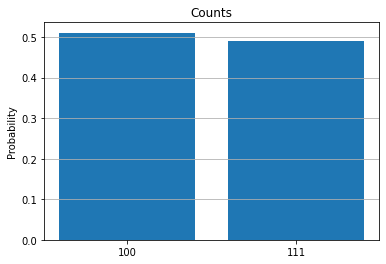

In [47]:
counts = simulate(program=grd_program, shots=1024)

plot_histogram(counts)

## Superdense coding

In [88]:
# Co może być wysłane: 00 - I, 01 - Z, 10 - X, 11 - ZX


def mess(k: ql.Kernel):
    # options = ["00", "01", "10", "11"]
    # r = np.random.randint(4)
    # random_option = np.random.choice(options)
    msg = random_state(2)
    print(msg)

    if msg == "01":
        k.z(0)
    if msg == "10":
        k.x(0)
    if msg == "11":
        k.z(0)
        k.x(0)


In [65]:
nqubits = 2

sc_p = ql.Program("superdense-coding", platform, nqubits)
k = ql.Kernel("kernel", platform, nqubits)

k.hadamard(0)
k.cnot(0, 1)

mess(k)

# Odczyt
k.cnot(1, 0)
k.hadamard(1)

k.measure(0)
k.measure(1)

sc_p.add_kernel(k)
sc_p.compile()


11


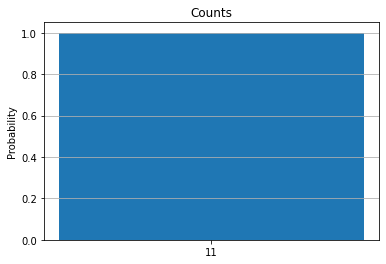

In [66]:
counts = simulate(program=sc_p, shots=1024)
plot_histogram(counts=counts)


## Deutsch-Jozsa algorithm

In [70]:
def oracle(nqubits):
    options = ["c", "b"]
    random_option = np.random.choice(options)
    print(random_option)

    if random_option == "c":
        rand = np.random.randint(2)
        for q in range(nqubits):
            if rand == 1:
                k.x(q)

    if random_option == "b":
        tab = [1, 0, 0, 1]
        # for q in range(len(tab)):
        for i, q in enumerate(tab):
            if q == 1:
                k.x(i)

        for q in range(nqubits - 1):
            k.cnot(q, nqubits - 1)
        
        # for q in range(len(tab)):
        for i, q in enumerate(tab):
            if tab[q] == 1:
                k.x(q)


In [71]:
nqubits = 5

dj_p = ql.Program("deutsch-jozsa", platform, nqubits)
k = ql.Kernel("kernel", platform, nqubits)

for q in range(nqubits - 1):
    k.hadamard(q)

k.x(nqubits - 1)
k.hadamard(nqubits - 1)

oracle(nqubits)

for q in range(nqubits - 1):
    k.hadamard(q)

for q in range(nqubits - 1):
    k.measure(q)

dj_p.add_kernel(k)
dj_p.compile()

# 0000-100% to funkcja stała, 0000-0% to funkcja zbalansowana


c


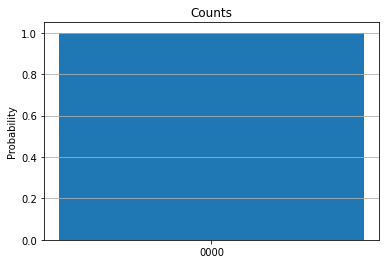

In [72]:
counts = simulate(program=dj_p, measured=range(nqubits - 1), shots=1)
plot_histogram(counts=counts)


## Simon's Algorithm

In [78]:
def oracle(nqubits: int, k: ql.Kernel, secret: str):
    for q in range(nqubits):
        k.cnot(q, q + nqubits)

    # sum = 0

    # for i in range(len(secret)):
    #     sum += secret[i]

    # if sum != 0:
    #     for i in range(len(secret)):
    #         if secret[i] == 1:
    #             value = i
    #             for i in range(len(secret)):
    #                 if secret[i] == 1:
    #                     k.cnot(value, nqubits + i)
    #             break

    if "1" in secret:
        for i, q in enumerate(secret):
            if q == "1":
                value = i
                for i, q in enumerate(secret):
                    if q == "1":
                        k.cnot(value, nqubits + i)
                break


In [80]:
nqubits = 3

secret = random_state(nqubits)
print(f"{secret=}")

p = ql.Program("simons", platform, 2 * nqubits)
k = ql.Kernel("kernel", platform, 2 * nqubits)

for q in range(nqubits):
    k.hadamard(q)

oracle(nqubits, k, secret)

for q in range(nqubits):
    k.hadamard(q)

for q in range(nqubits):
    k.measure(q)

p.add_kernel(k)
p.compile()


secret='001'


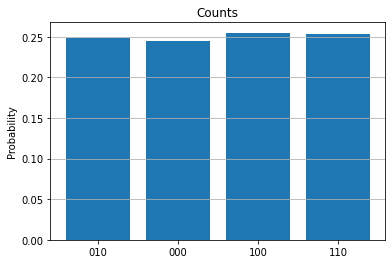

In [87]:
counts = simulate(program=p, measured=range(nqubits), shots=1024)
plot_histogram(counts=counts)


In [29]:
#Na podstawie wyników można znaleźć secret (można to też dodać)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dedd1051-cb34-4841-b8e5-79089caae121' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>